In [1]:
# Joaquin Rivera (jdr322)
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# Convert All JPEG files to BMP
from PIL import Image
import os

# Directories
jpeg_dir = "training_set/scissors" # Change these paths to the class you need to change
bmp_dir = "training_set_bmp/scissors"

# Ensure the BMP directory exists
os.makedirs(bmp_dir, exist_ok=True)

# Convert all JPEG images to BMP
for filename in os.listdir(jpeg_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img = Image.open(os.path.join(jpeg_dir, filename))
        bmp_filename = os.path.splitext(filename)[0] + ".bmp"  # Change extension to .bmp
        img.save(os.path.join(bmp_dir, bmp_filename), format="BMP")


In [ ]:
# Changes all bmp files from 96x96 to 32x32 (nned to apply to both training and testing set)
def resize_images(input_dir, output_dir, size=(32, 32)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_resized = img.resize(size)
            img_resized.save(os.path.join(output_class_dir, img_name))

resize_images('testing_set_bmp', 'testing_set_bmp', size=(32, 32))


In [7]:
# Define paths to training and testing sets
train_dir = "training_set_bmp"
test_dir = "testing_set_bmp"

# Create ImageDataGenerator to normalize pixel values and apply random brightness
datagen = ImageDataGenerator(rescale=1.0/255.0, brightness_range=[.5,1.5])

In [8]:
# Load images from directories
train_generator_all = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

# Print class labels
print("Class indices:", train_generator_all.class_indices)

Found 500 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Class indices: {'paper': 0, 'rock': 1, 'scissors': 2}


In [9]:
# Create training and validation split
X_train, y_train = [], []
for _ in range(len(train_generator_all)):
    imgs, labels = next(train_generator_all)
    X_train.extend(imgs)
    y_train.extend(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Split into 400 training and 100 validation images
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=100, train_size=400, stratify=y_train, random_state=42)

In [10]:
# Define TinyMaix-compatible CNN architecture
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', strides=1, padding='same', input_shape=(32, 32, 1)),  
    layers.Conv2D(16, (3,3), activation='relu', strides=2, padding='same'),  # Replaces MaxPooling2D

    layers.Conv2D(32, (3,3), activation='relu', strides=1, padding='same'),
    layers.Conv2D(32, (3,3), activation='relu', strides=2, padding='same'),  # Replaces MaxPooling2D

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
13/13 [==============================] - 2s 44ms/step - loss: 1.0973 - accuracy: 0.3500 - val_loss: 1.0909 - val_accuracy: 0.4700
Epoch 2/30
13/13 [==============================] - 0s 23ms/step - loss: 1.0864 - accuracy: 0.3625 - val_loss: 1.0693 - val_accuracy: 0.3300
Epoch 3/30
13/13 [==============================] - 0s 23ms/step - loss: 1.0723 - accuracy: 0.4150 - val_loss: 1.0375 - val_accuracy: 0.3500
Epoch 4/30
13/13 [==============================] - 0s 22ms/step - loss: 1.0502 - accuracy: 0.4375 - val_loss: 1.0087 - val_accuracy: 0.5500
Epoch 5/30
13/13 [==============================] - 0s 22ms/step - loss: 0.9678 - accuracy: 0.5525 - val_loss: 0.9098 - val_accuracy: 0.6100
Epoch 6/30
13/13 [==============================] - 0s 22ms/step - loss: 0.8876 - accuracy: 0.6025 - val_loss: 0.7746 - val_accuracy: 0.7100
Epoch 7/30
13/13 [==============================] - 0s 22ms/step - loss: 0.7970 - accuracy: 0.6225 - val_loss: 0.8765 - val_accuracy: 0.6000
Epoch 8/30
13

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

4/4 [==============================] - 1s 334ms/step - loss: 0.9516 - accuracy: 0.8100
Test Accuracy: 81.00%


In [18]:
model.save("final_model.h5")

c:\Users\joaqu\.conda\envs\joaquiniscool\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 46ms/step


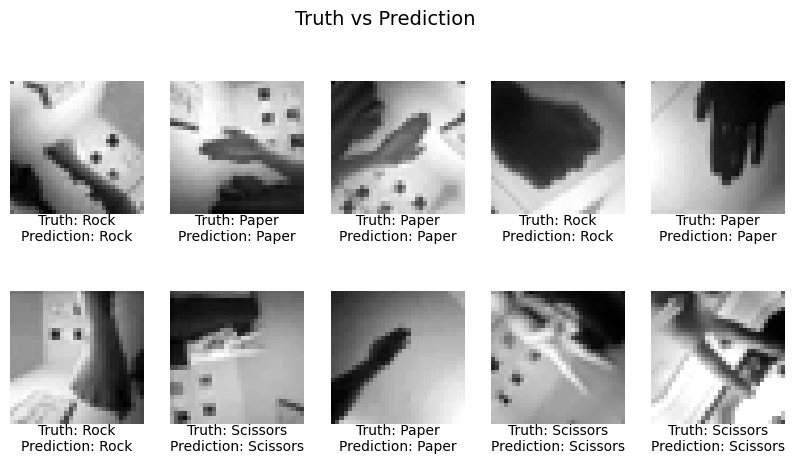

In [22]:
classes = ['Paper', 'Rock', 'Scissors']
imgs, labels = next(test_generator)
fig = plt.figure(0, figsize=(10, 5))
fig.suptitle("Truth vs Prediction", fontsize=14)
plt.tight_layout(pad=2.0)

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    truth = classes[np.argmax(labels[i])]
    pred = classes[np.argmax(model.predict(np.expand_dims(imgs[i], axis=0)))]

    ax.text(0.5, -0.2, f"Truth: {truth}\nPrediction: {pred}", 
            fontsize=10, ha='center', transform=ax.transAxes)  # Move label below image
    ax.imshow(imgs[i], cmap='gray')
    ax.axis('off')

plt.show()

